In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.store import DataStore
from src.config import INSTRUMENTS
# Visual Settings
sns.set_style("darkgrid")
%matplotlib inline
print("✅ Environment Ready.")

✅ Environment Ready.


Load Data from Vault

In [2]:
store = DataStore()

# DEFINITION: Choose your Pair here
# Ensure these keys exist in your ArcticDB (via download_history.py)
ASSET_Y = 'JPM_STK' 
ASSET_X = 'BAC_STK' 

print(f"Loading {ASSET_Y} and {ASSET_X}...")
try: 
    df_y = store.load(ASSET_Y)
    df_x = store.load(ASSET_X)
    
    # Align DataFrames on Index (Time) to ensure we compare apples to apples
    df = pd.concat([df_y['close'], df_x['close']], axis=1, join='inner')
    df.columns = ['Y', 'X']
    
    print(f"✅ Data Aligned. Rows: {len(df)}")
    display(df.head())
except Exception as e:
    print(f"❌ Error loading data: {e}")
    print("Did you run tools/download_history.py?")

Loading JPM_STK and BAC_STK...
✅ Data Aligned. Rows: 11292


,Y,X
date,,
2025-11-12 09:30:00-05:00,316.63,53.85
2025-11-12 09:31:00-05:00,317.73,53.95
2025-11-12 09:32:00-05:00,317.62,53.93
2025-11-12 09:33:00-05:00,317.92,53.95
2025-11-12 09:34:00-05:00,318.76,54.04


The Kalman Filter (Research Version)
We re-implement the logic here "inline" so we can easily record internal states like covariance and beta for plotting.

In [3]:
def run_kalman_research(data, delta=1e-4, R=1e-3):
    """
    Runs the Kalman Filter over the dataframe and returns history of:
    - Slope (Beta)
    - Intercept
    - Error (Innovation)
    - Variance of Error
    """
    # Initialize State
    # x = [intercept, slope]
    state_mean = np.zeros(2)
    state_cov = np.ones((2, 2)) # High uncertainty start
    Q = np.eye(2) * delta       # Process Noise
    
    # Storage
    betas = []
    intercepts = []
    errors = []
    sqrt_S_list = [] # Standard Deviation of Error
    
    # Iterate
    for i in range(len(data)):
        y = data.iloc[i]['Y']
        x = data.iloc[i]['X']
        
        # 1. Predict
        state_mean_prior = state_mean
        state_cov_prior = state_cov + Q
        
        # 2. Update
        H = np.array([1.0, x]) # Observation matrix
        
        y_hat = H @ state_mean_prior
        error = y - y_hat
        
        S = H @ state_cov_prior @ H.T + R # Innovation Covariance
        K = state_cov_prior @ H.T / S     # Kalman Gain
        
        state_mean = state_mean_prior + K * error
        state_cov = state_cov_prior - np.outer(K, H) @ state_cov_prior
        
        # Store
        betas.append(state_mean[1])
        intercepts.append(state_mean[0])
        errors.append(error)
        sqrt_S_list.append(np.sqrt(S))
        
    return pd.DataFrame({
        'beta': betas,
        'intercept': intercepts,
        'error': errors,
        'std_dev': sqrt_S_list
    }, index=data.index)

print("✅ Logic Defined.")

✅ Logic Defined.


The Sensitivity Test (The Critical Step)
We will run the filter with THREE different delta values to see how the "Hedge Ratio" behaves.

In [4]:
# Hypotheses
deltas = {
    'Static (Low Adaptivity)': 1e-6,
    'Balanced (Default)': 1e-4,
    'Reactive (High Noise)': 1e-2
}

results = {}

print("🧪 Running Sensitivity Analysis...")
for name, d in deltas.items():
    print(f"   -> Testing {name} (delta={d})...")
    res = run_kalman_research(df, delta=d)
    res['z_score'] = res['error'] / res['std_dev']
    results[name] = res

print("✅ Calculation Complete.")

🧪 Running Sensitivity Analysis...
   -> Testing Static (Low Adaptivity) (delta=1e-06)...
   -> Testing Balanced (Default) (delta=0.0001)...
   -> Testing Reactive (High Noise) (delta=0.01)...
✅ Calculation Complete.


Visualization & Analysis
Plotting the Beta (Hedge Ratio) over time tells us if the relationship is stable or chaotic.

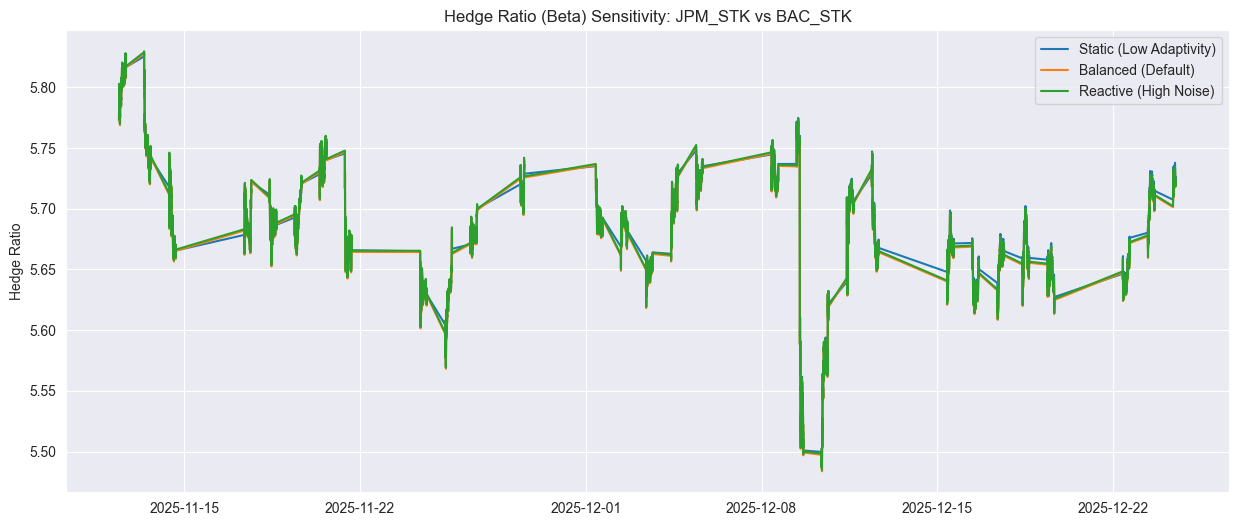

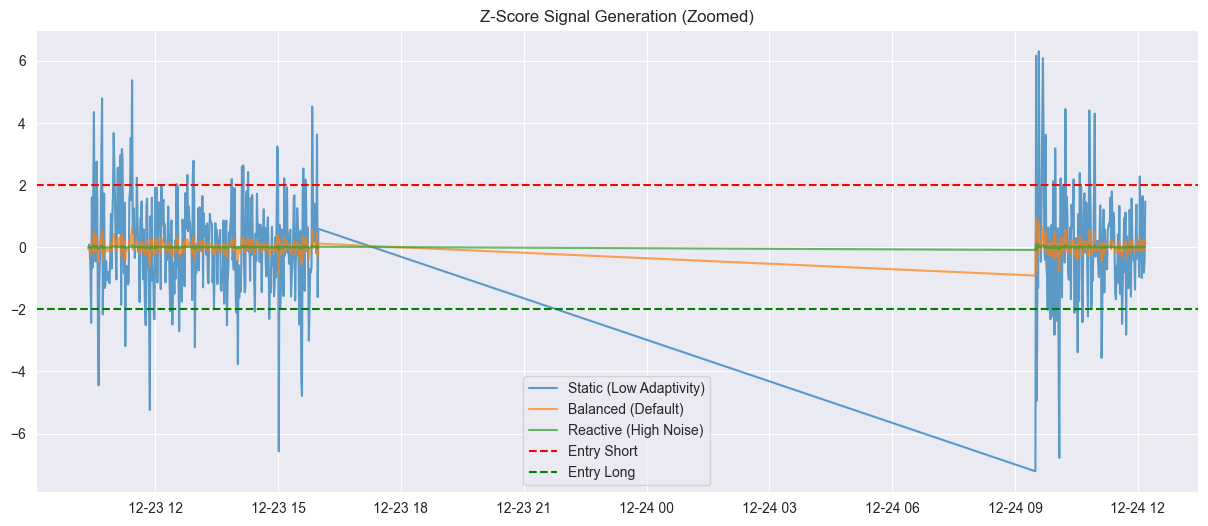

In [5]:
# 1. Plot Beta Evolution
plt.figure(figsize=(15, 6))
for name, res in results.items():
    plt.plot(res.index, res['beta'], label=f"{name}")

plt.title(f"Hedge Ratio (Beta) Sensitivity: {ASSET_Y} vs {ASSET_X}")
plt.ylabel("Hedge Ratio")
plt.legend()
plt.show()

# 2. Plot Z-Scores (Signal Generation)
# We only look at the last 500 bars to zoom in on detail
zoom = 500
plt.figure(figsize=(15, 6))
for name, res in results.items():
    plt.plot(res.index[-zoom:], res['z_score'][-zoom:], label=f"{name}", alpha=0.7)

plt.axhline(2.0, color='red', linestyle='--', label='Entry Short')
plt.axhline(-2.0, color='green', linestyle='--', label='Entry Long')
plt.title("Z-Score Signal Generation (Zoomed)")
plt.legend()
plt.show()

--- 📊 DIAGNOSTICS: PREVIOUS RUN ---
[Static (Low Adaptivity)] MSE: 8.908746 | Volatility (StdDev): 2.5539
[Balanced (Default)] MSE: 8.908069 | Volatility (StdDev): 0.3250
[Reactive (High Noise)] MSE: 8.908084 | Volatility (StdDev): 0.0629

--- 🎯 FINE-TUNING: SEARCHING LOWER DELTAS ---
   -> Testing Fine-Tune A (5e-6)...
   -> Testing Fine-Tune B (1e-5)...


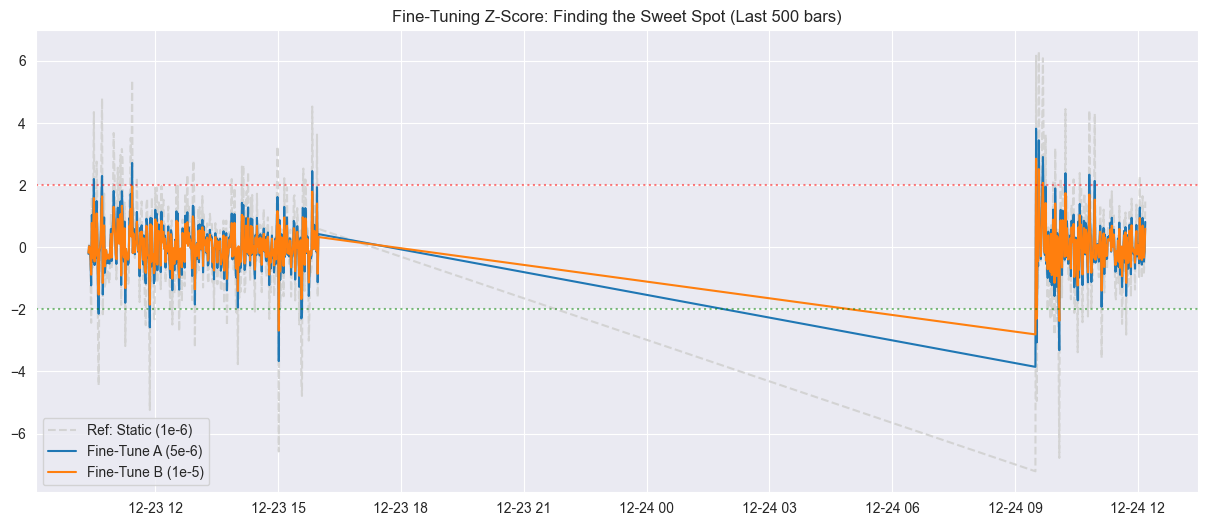

In [9]:
### CELL 6: Analysis & Fine-Tuning ###

print("--- 📊 DIAGNOSTICS: PREVIOUS RUN ---")
# 1. Check MSE (Mean Squared Error) for the previous run
# If MSE is too low (near 0), the filter is "overfitting" (hugging the price too tight).
for name, res in results.items():
    mse = (res['error']**2).mean()
    print(f"[{name}] MSE: {mse:.6f} | Volatility (StdDev): {res['z_score'].std():.4f}")

print("\n--- 🎯 FINE-TUNING: SEARCHING LOWER DELTAS ---")
# We know 1e-4 was too fast (flatline). We know 1e-6 was active.
# Let's test the "Middle Ground" to see if we can get better mean reversion without being static.
fine_tune_deltas = {
    'Fine-Tune A (5e-6)': 5e-6,
    'Fine-Tune B (1e-5)': 1e-5,
}

fine_results = {}

for name, d in fine_tune_deltas.items():
    print(f"   -> Testing {name}...")
    res = run_kalman_research(df, delta=d)
    res['z_score'] = res['error'] / res['std_dev']
    fine_results[name] = res

# Plot the Fine-Tuned Results
plt.figure(figsize=(15, 6))

# Plot the original 'Static' for reference
plt.plot(results['Static (Low Adaptivity)'].index[-zoom:], 
         results['Static (Low Adaptivity)']['z_score'][-zoom:], 
         label='Ref: Static (1e-6)', color='lightgray', linestyle='--')

# Plot new candidates
for name, res in fine_results.items():
    plt.plot(res.index[-zoom:], res['z_score'][-zoom:], label=name)

plt.axhline(2.0, color='red', linestyle=':', alpha=0.5)
plt.axhline(-2.0, color='green', linestyle=':', alpha=0.5)
plt.title(f"Fine-Tuning Z-Score: Finding the Sweet Spot (Last {zoom} bars)")
plt.legend()
plt.show()

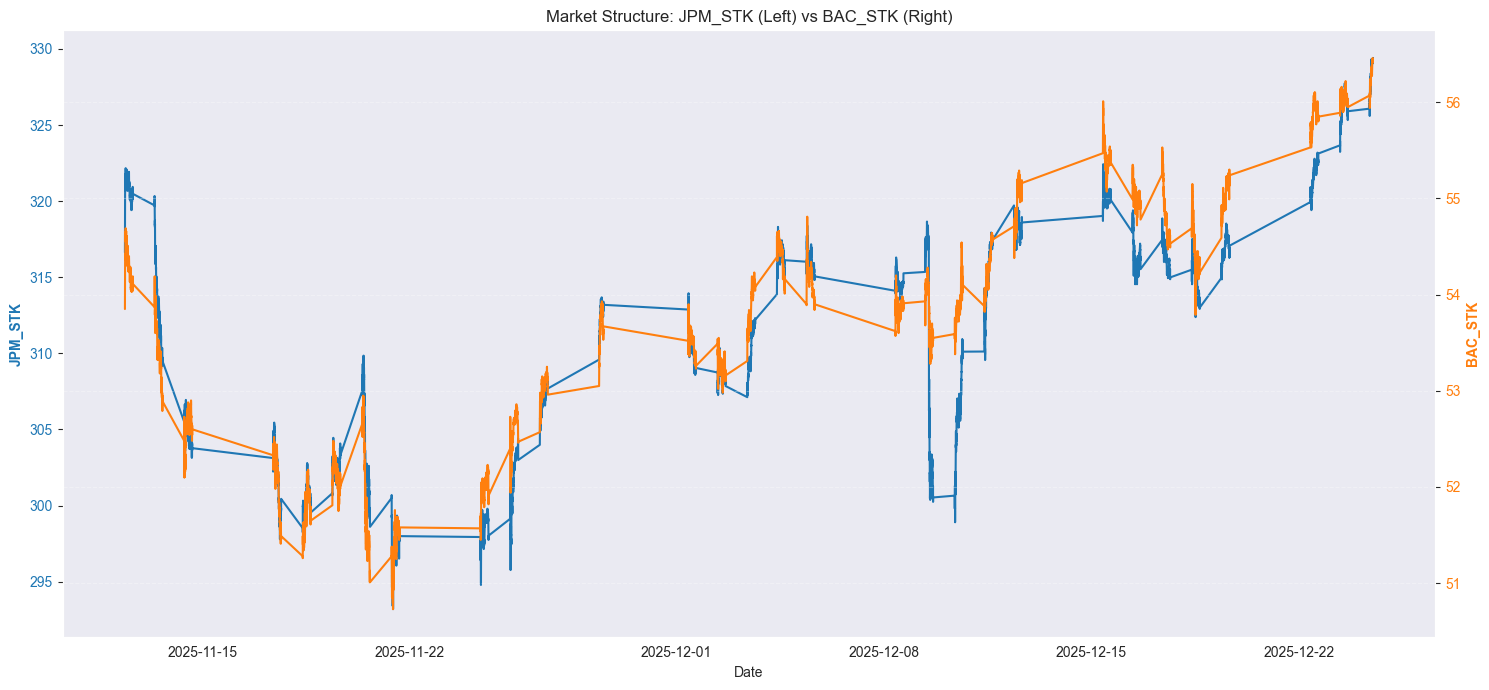

In [8]:
### CELL 7: Raw Price Action ###

# Create a dual-axis plot to compare the raw price movements
fig, ax1 = plt.subplots(figsize=(15, 7))

color_1 = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel(ASSET_Y, color=color_1, fontweight='bold')
ax1.plot(df.index, df['Y'], color=color_1, label=ASSET_Y, linewidth=1.5)
ax1.tick_params(axis='y', labelcolor=color_1)
ax1.grid(False) # Turn off grid for primary axis to avoid clutter

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  
color_2 = 'tab:orange'
ax2.set_ylabel(ASSET_X, color=color_2, fontweight='bold')
ax2.plot(df.index, df['X'], color=color_2, label=ASSET_X, linewidth=1.5)
ax2.tick_params(axis='y', labelcolor=color_2)
ax2.grid(True, linestyle='--', alpha=0.3) # Soft grid for secondary axis

plt.title(f'Market Structure: {ASSET_Y} (Left) vs {ASSET_X} (Right)')
fig.tight_layout()
plt.show()

🚀 RUNNING BACKTEST: delta=5e-06 | Entry=2.0 | Exit=0.0


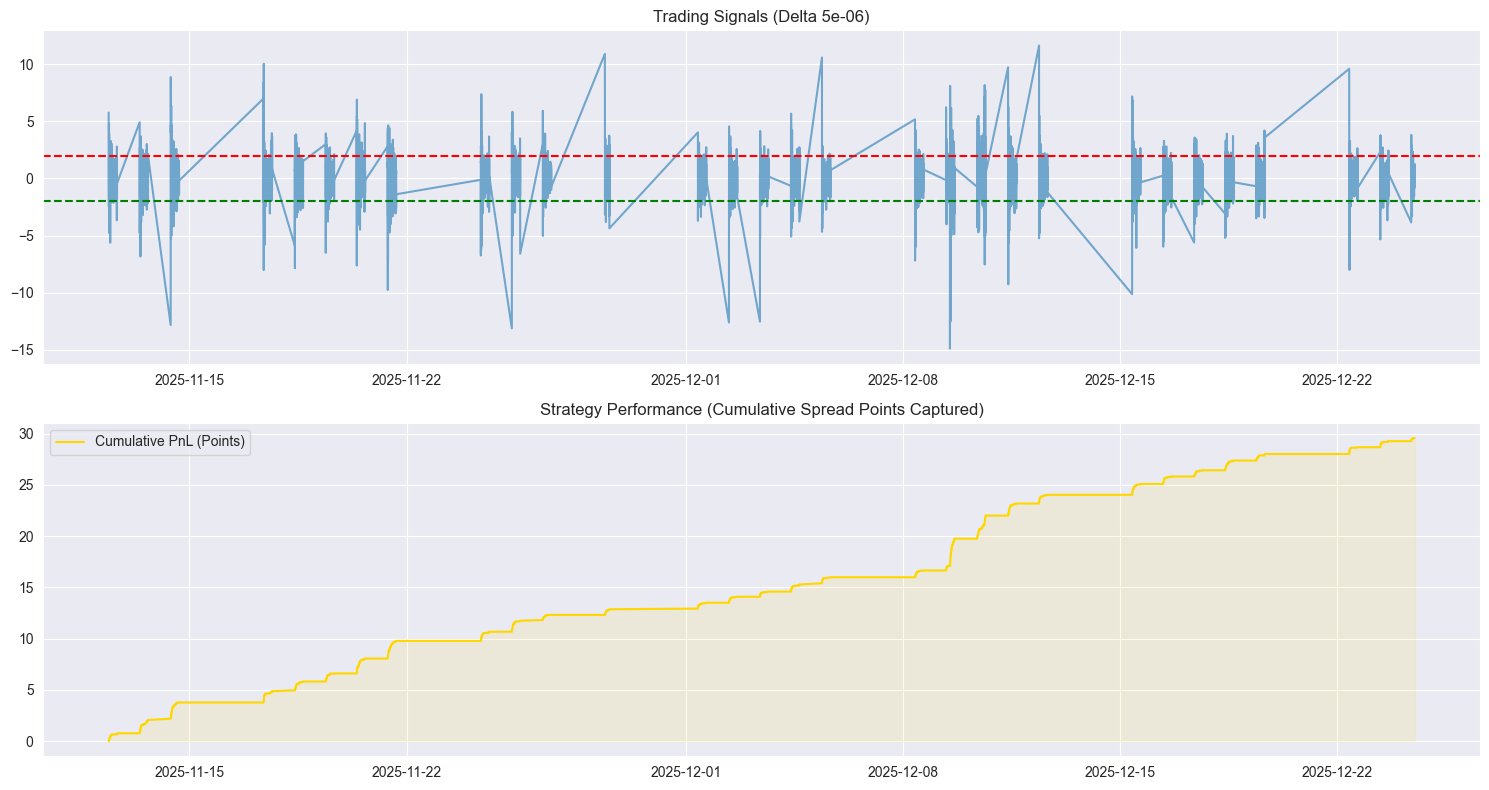

🏁 Total Trades: 1636
💰 Final PnL (Spread Points): 29.5734


In [10]:
### CELL 8: Strategy Backtest ###

# --- CONFIGURATION ---
CHOSEN_DELTA = 5e-6  # The winner from our analysis
ENTRY_THRESHOLD = 2.0
EXIT_THRESHOLD = 0.0  # Mean reversion target
CAPITAL = 100000      # $100k portfolio

print(f"🚀 RUNNING BACKTEST: delta={CHOSEN_DELTA} | Entry={ENTRY_THRESHOLD} | Exit={EXIT_THRESHOLD}")

# 1. Generate Signals
# We re-run the Kalman filter one last time with the specific chosen delta
strategy_data = run_kalman_research(df, delta=CHOSEN_DELTA)
strategy_data['z_score'] = strategy_data['error'] / strategy_data['std_dev']

# 2. Logic Vectors
strategy_data['long_signal'] = strategy_data['z_score'] < -ENTRY_THRESHOLD
strategy_data['short_signal'] = strategy_data['z_score'] > ENTRY_THRESHOLD
strategy_data['exit_signal'] = abs(strategy_data['z_score']) < 0.5 # Exit near mean

# 3. Iterate to manage positions (Vectorized backtests are hard with stateful exits)
position = 0 # 0=Flat, 1=Long Spread, -1=Short Spread
entry_price_spread = 0.0
pnl = []
trades = []

# Price of the spread ~ Y - (Beta * X)
# Note: In real trading, you hold amounts of Y and X. 
# Here we simplify PnL tracking to the "Spread Value" for quick validation.
y_prices = df['Y'].values
x_prices = df['X'].values
betas = strategy_data['beta'].values
z_scores = strategy_data['z_score'].values

current_pnl = 0.0

for i in range(len(strategy_data)):
    # Calculate value of spread at this moment
    # Spread = JPM - (HedgeRatio * BAC)
    current_spread_val = y_prices[i] - (betas[i] * x_prices[i])
    z = z_scores[i]
    
    # Check Exits first
    if position == 1 and z > -EXIT_THRESHOLD: # Exit Long
        # PnL = (Current Spread - Entry Spread)
        trade_pnl = current_spread_val - entry_price_spread
        current_pnl += trade_pnl
        position = 0
        trades.append({'idx': i, 'type': 'EXIT_LONG', 'pnl': trade_pnl})
        
    elif position == -1 and z < EXIT_THRESHOLD: # Exit Short
        # PnL = (Entry Spread - Current Spread)
        trade_pnl = entry_price_spread - current_spread_val
        current_pnl += trade_pnl
        position = 0
        trades.append({'idx': i, 'type': 'EXIT_SHORT', 'pnl': trade_pnl})

    # Check Entries (only if flat)
    if position == 0:
        if z < -ENTRY_THRESHOLD: # Long the Spread (Buy Y, Sell X)
            position = 1
            entry_price_spread = current_spread_val
            trades.append({'idx': i, 'type': 'ENTRY_LONG', 'pnl': 0})
            
        elif z > ENTRY_THRESHOLD: # Short the Spread (Sell Y, Buy X)
            position = -1
            entry_price_spread = current_spread_val
            trades.append({'idx': i, 'type': 'ENTRY_SHORT', 'pnl': 0})
            
    pnl.append(current_pnl)

strategy_data['cumulative_pnl'] = pnl

# 4. Visualization
plt.figure(figsize=(15, 8))

# Top Panel: Z-Score and Signals
ax1 = plt.subplot(2, 1, 1)
ax1.plot(strategy_data.index, strategy_data['z_score'], label='Z-Score', alpha=0.6)
ax1.axhline(ENTRY_THRESHOLD, color='red', linestyle='--')
ax1.axhline(-ENTRY_THRESHOLD, color='green', linestyle='--')
ax1.set_title(f"Trading Signals (Delta {CHOSEN_DELTA})")

# Bottom Panel: PnL
ax2 = plt.subplot(2, 1, 2)
ax2.plot(strategy_data.index, strategy_data['cumulative_pnl'], color='gold', label='Cumulative PnL (Points)')
ax2.fill_between(strategy_data.index, strategy_data['cumulative_pnl'], color='gold', alpha=0.1)
ax2.set_title("Strategy Performance (Cumulative Spread Points Captured)")
ax2.legend()

plt.tight_layout()
plt.show()

print(f"🏁 Total Trades: {len(trades)}")
print(f"💰 Final PnL (Spread Points): {current_pnl:.4f}")

🚀 RUNNING STRESS TEST: Entry=4.5 | Exit=1.0


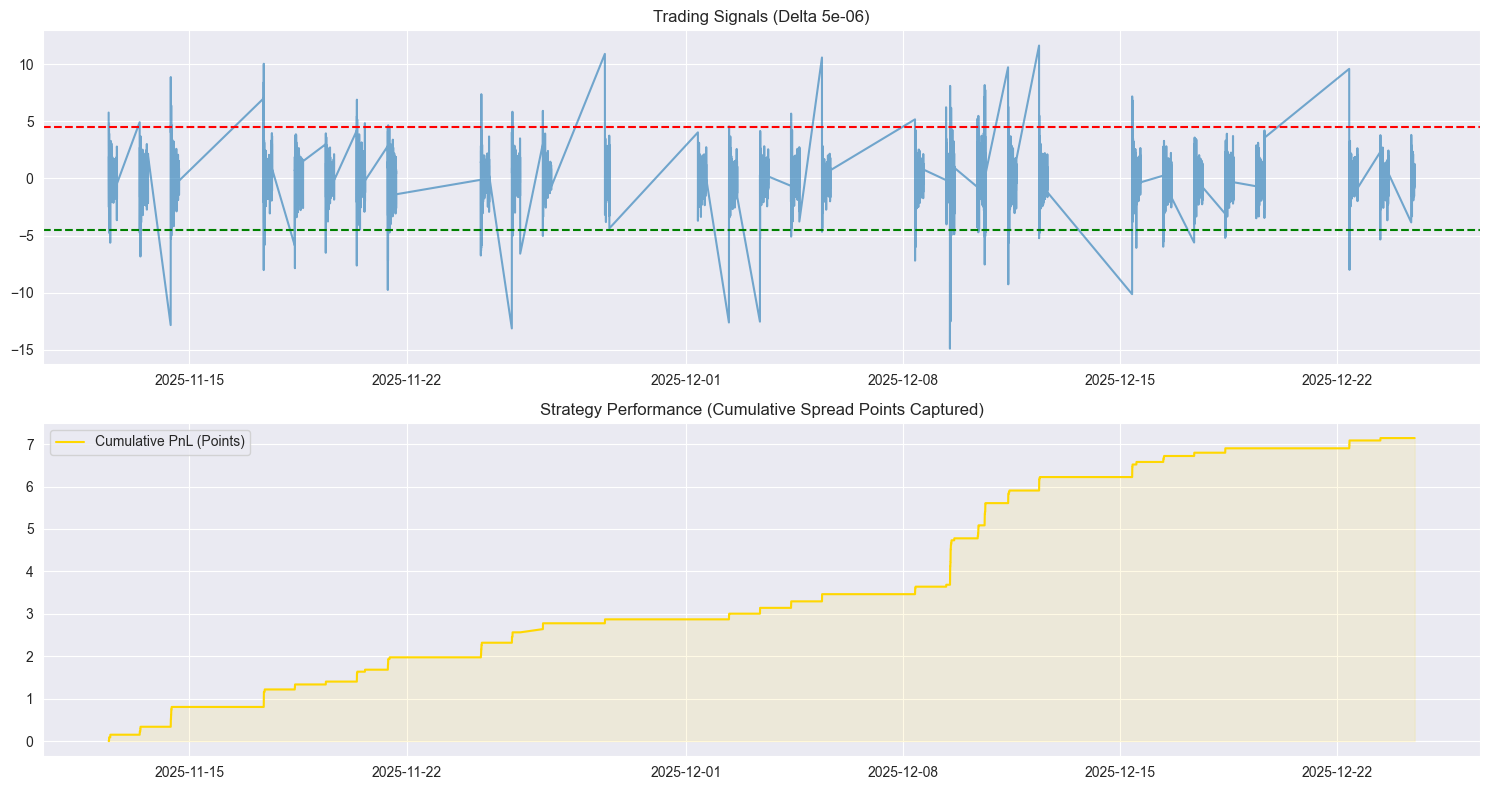

🏁 Total Trades: 228
💰 Final PnL (Spread Points): 7.1440


In [11]:
# --- RE-CONFIGURATION ---
# We are raising the bar to filter out the "pennies" and catch the "dollars"
ENTRY_THRESHOLD = 4.5  # Increased from 2.0
EXIT_THRESHOLD = 1.0   # Don't wait for perfect 0.0, take profit earlier
CAPITAL = 100000

print(f"🚀 RUNNING STRESS TEST: Entry={ENTRY_THRESHOLD} | Exit={EXIT_THRESHOLD}")


# 1. Generate Signals
# We re-run the Kalman filter one last time with the specific chosen delta
strategy_data = run_kalman_research(df, delta=CHOSEN_DELTA)
strategy_data['z_score'] = strategy_data['error'] / strategy_data['std_dev']

# 2. Logic Vectors
strategy_data['long_signal'] = strategy_data['z_score'] < -ENTRY_THRESHOLD
strategy_data['short_signal'] = strategy_data['z_score'] > ENTRY_THRESHOLD
strategy_data['exit_signal'] = abs(strategy_data['z_score']) < 0.5 # Exit near mean

# 3. Iterate to manage positions (Vectorized backtests are hard with stateful exits)
position = 0 # 0=Flat, 1=Long Spread, -1=Short Spread
entry_price_spread = 0.0
pnl = []
trades = []

# Price of the spread ~ Y - (Beta * X)
# Note: In real trading, you hold amounts of Y and X. 
# Here we simplify PnL tracking to the "Spread Value" for quick validation.
y_prices = df['Y'].values
x_prices = df['X'].values
betas = strategy_data['beta'].values
z_scores = strategy_data['z_score'].values

current_pnl = 0.0

for i in range(len(strategy_data)):
    # Calculate value of spread at this moment
    # Spread = JPM - (HedgeRatio * BAC)
    current_spread_val = y_prices[i] - (betas[i] * x_prices[i])
    z = z_scores[i]
    
    # Check Exits first
    if position == 1 and z > -EXIT_THRESHOLD: # Exit Long
        # PnL = (Current Spread - Entry Spread)
        trade_pnl = current_spread_val - entry_price_spread
        current_pnl += trade_pnl
        position = 0
        trades.append({'idx': i, 'type': 'EXIT_LONG', 'pnl': trade_pnl})
        
    elif position == -1 and z < EXIT_THRESHOLD: # Exit Short
        # PnL = (Entry Spread - Current Spread)
        trade_pnl = entry_price_spread - current_spread_val
        current_pnl += trade_pnl
        position = 0
        trades.append({'idx': i, 'type': 'EXIT_SHORT', 'pnl': trade_pnl})

    # Check Entries (only if flat)
    if position == 0:
        if z < -ENTRY_THRESHOLD: # Long the Spread (Buy Y, Sell X)
            position = 1
            entry_price_spread = current_spread_val
            trades.append({'idx': i, 'type': 'ENTRY_LONG', 'pnl': 0})
            
        elif z > ENTRY_THRESHOLD: # Short the Spread (Sell Y, Buy X)
            position = -1
            entry_price_spread = current_spread_val
            trades.append({'idx': i, 'type': 'ENTRY_SHORT', 'pnl': 0})
            
    pnl.append(current_pnl)

strategy_data['cumulative_pnl'] = pnl

# 4. Visualization
plt.figure(figsize=(15, 8))

# Top Panel: Z-Score and Signals
ax1 = plt.subplot(2, 1, 1)
ax1.plot(strategy_data.index, strategy_data['z_score'], label='Z-Score', alpha=0.6)
ax1.axhline(ENTRY_THRESHOLD, color='red', linestyle='--')
ax1.axhline(-ENTRY_THRESHOLD, color='green', linestyle='--')
ax1.set_title(f"Trading Signals (Delta {CHOSEN_DELTA})")

# Bottom Panel: PnL
ax2 = plt.subplot(2, 1, 2)
ax2.plot(strategy_data.index, strategy_data['cumulative_pnl'], color='gold', label='Cumulative PnL (Points)')
ax2.fill_between(strategy_data.index, strategy_data['cumulative_pnl'], color='gold', alpha=0.1)
ax2.set_title("Strategy Performance (Cumulative Spread Points Captured)")
ax2.legend()

plt.tight_layout()
plt.show()

print(f"🏁 Total Trades: {len(trades)}")
print(f"💰 Final PnL (Spread Points): {current_pnl:.4f}")

In [12]:
### CELL 9: Kelly Criterion & Position Sizing ###

# --- 1. Analyze Trade Statistics ---
# Convert the trade list from the previous cell into a DataFrame
trade_df = pd.DataFrame(trades)

# Filter out zero PnL entries (open trades) for accurate stats
completed_trades = trade_df[trade_df['pnl'] != 0]

wins = completed_trades[completed_trades['pnl'] > 0]
losses = completed_trades[completed_trades['pnl'] <= 0]

win_rate = len(wins) / len(completed_trades)
avg_win = wins['pnl'].mean()
avg_loss = abs(losses['pnl'].mean())
win_loss_ratio = avg_win / avg_loss

print(f"📊 STRATEGY STATISTICS (Based on {len(completed_trades)} completed trades)")
print(f"   Win Rate:      {win_rate:.2%}")
print(f"   Avg Win:       {avg_win:.4f} pts")
print(f"   Avg Loss:      {avg_loss:.4f} pts")
print(f"   Reward/Risk:   {win_loss_ratio:.2f}")

# --- 2. Calculate Kelly Fraction ---
# Kelly Formula: K = W - [(1 - W) / R]
# W = Win Probability, R = Win/Loss Ratio
kelly_fraction = win_rate - ((1 - win_rate) / win_loss_ratio)

print(f"   Kelly Fraction (Full):  {kelly_fraction:.2%}")

# --- 3. Safety Adjustment (Half-Kelly) ---
# Traders rarely use Full Kelly because it is extremely volatile. 
# We use "Half-Kelly" for a safer growth curve.
safe_kelly = kelly_fraction * 0.5
print(f"   🛡️ TARGET ALLOCATION (Half-Kelly): {safe_kelly:.2%}")

if safe_kelly <= 0:
    print("\n❌ STOP: The strategy has a negative expectancy or negative Kelly.")
    print("   Do not trade this live. Return to Step 6 and improve signal quality.")
else:
    # --- 4. Concrete Position Sizing ---
    # Current Market Prices (Last known close)
    price_y = df['Y'].iloc[-1] # JPM
    price_x = df['X'].iloc[-1] # BAC
    current_beta = strategy_data['beta'].iloc[-1] # Current Hedge Ratio

    # Capital Allocation
    allocatable_capital = CAPITAL * safe_kelly
    
    # We want to be Dollar Neutral(ish).
    # 1 Unit = 1 Share of Y + (Beta) Shares of X
    # Cost per Unit approx = Price_Y + (Beta * Price_X * Margin_Requirement)
    # For simplicity, we assume we use cash for the Long leg and margin for the Short leg.
    # We size based on the Long Leg (Y) Exposure.
    
    # How much JPM can we buy with this capital?
    jpm_shares = int(allocatable_capital / price_y)
    
    # How much BAC do we need to hedge it?
    bac_shares = int(jpm_shares * current_beta)

    print("\n🚀 LIVE TRADE RECOMMENDATION")
    print(f"   Account Size:   ${CAPITAL:,.2f}")
    print(f"   Allocated Cash: ${allocatable_capital:,.2f} ({safe_kelly:.1%} of account)")
    print("-" * 30)
    print(f"   🔵 LONG LEG ({ASSET_Y}):  Buy {jpm_shares} shares")
    print(f"   🟠 SHORT LEG ({ASSET_X}): Sell {bac_shares} shares")
    print("-" * 30)
    print(f"   Est. Notional Value: ${jpm_shares * price_y:,.2f} vs ${bac_shares * price_x:,.2f}")

📊 STRATEGY STATISTICS (Based on 114 completed trades)
   Win Rate:      99.12%
   Avg Win:       0.0632 pts
   Avg Loss:      0.0029 pts
   Reward/Risk:   21.81
   Kelly Fraction (Full):  99.08%
   🛡️ TARGET ALLOCATION (Half-Kelly): 49.54%

🚀 LIVE TRADE RECOMMENDATION
   Account Size:   $100,000.00
   Allocated Cash: $49,541.29 (49.5% of account)
------------------------------
   🔵 LONG LEG (JPM_STK):  Buy 150 shares
   🟠 SHORT LEG (BAC_STK): Sell 858 shares
------------------------------
   Est. Notional Value: $49,407.00 vs $48,425.52


📉 APPLING FRICTION TO 228 TRADES...
   Position: 150 JPM / 858 BAC (Total 1008 shares/trade)
   Cost per Trade: $30.24 (Entry + Exit)


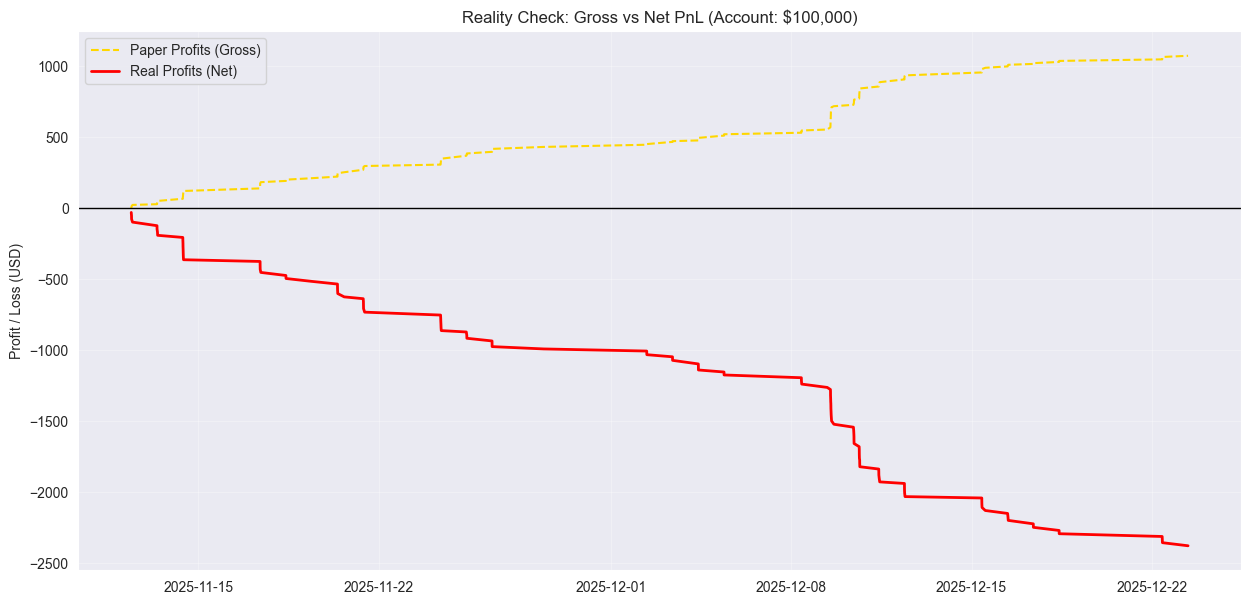

💰 FINAL GROSS PnL: $1,071.59
💸 FINAL NET PnL:   $-2,375.77

🚨 CONCLUSION: The strategy is 'Churning'.
   The alpha (Gross PnL) is positive, but it is smaller than the friction.
   SOLUTION: We must increase the 'Average Win' by trading less frequently.


In [13]:
### CELL 10: The Realism Check (Adding Costs) ###

# --- CONFIGURATION ---
# Costs per share (Round Trip is calculated in logic)
COMMISSION_PER_SHARE = 0.005  # Standard IBKR/Tiered rate
SLIPPAGE_PER_SHARE   = 0.01   # Estimated cost to cross the spread (very conservative)

# Fixed Position Sizes (From your Kelly Calculation)
SIZE_Y = 150  # JPM Shares
SIZE_X = 858  # BAC Shares
TOTAL_SHARES = SIZE_Y + SIZE_X

print(f"📉 APPLING FRICTION TO {len(trades)} TRADES...")
print(f"   Position: {SIZE_Y} JPM / {SIZE_X} BAC (Total {TOTAL_SHARES} shares/trade)")
print(f"   Cost per Trade: ${(COMMISSION_PER_SHARE + SLIPPAGE_PER_SHARE) * TOTAL_SHARES * 2:.2f} (Entry + Exit)")

# --- CALCULATION ---
realism_data = []
cumulative_gross = 0.0
cumulative_net = 0.0

for t in trades:
    if t['pnl'] == 0: continue # Skip open trades
    
    # 1. Calculate Gross PnL in Dollars
    # Spread Points * Number of "Spread Units" (Shares of Y)
    gross_pnl_dollars = t['pnl'] * SIZE_Y
    
    # 2. Calculate Transaction Costs (Entry + Exit)
    # Cost = Total Shares * (Comm + Slip) * 2 (Round Trip)
    trade_cost = TOTAL_SHARES * (COMMISSION_PER_SHARE + SLIPPAGE_PER_SHARE) * 2
    
    # 3. Net PnL
    net_pnl_dollars = gross_pnl_dollars - trade_cost
    
    cumulative_gross += gross_pnl_dollars
    cumulative_net += net_pnl_dollars
    
    realism_data.append({
        'idx': t['idx'],
        'gross_pnl': cumulative_gross,
        'net_pnl': cumulative_net
    })

realism_df = pd.DataFrame(realism_data).set_index('idx')

# --- VISUALIZATION ---
plt.figure(figsize=(15, 7))

# Align the index with the original dataframe timestamps for plotting
# We map the integer 'idx' back to the 'df.index'
plot_dates = df.index[realism_df.index]

plt.plot(plot_dates, realism_df['gross_pnl'], label='Paper Profits (Gross)', color='gold', linestyle='--')
plt.plot(plot_dates, realism_df['net_pnl'], label='Real Profits (Net)', color='red', linewidth=2)

plt.title(f"Reality Check: Gross vs Net PnL (Account: ${CAPITAL:,.0f})")
plt.ylabel("Profit / Loss (USD)")
plt.axhline(0, color='black', linewidth=1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"💰 FINAL GROSS PnL: ${cumulative_gross:,.2f}")
print(f"💸 FINAL NET PnL:   ${cumulative_net:,.2f}")

if cumulative_net < 0:
    print("\n🚨 CONCLUSION: The strategy is 'Churning'.")
    print("   The alpha (Gross PnL) is positive, but it is smaller than the friction.")
    print("   SOLUTION: We must increase the 'Average Win' by trading less frequently.")

In [14]:
### CELL 11: Parameter Grid Search ###

import itertools

# --- CONFIGURATION ---
# We center our search around your current "best" guess, but go wider/stricter
param_grid = {
    'delta': [1e-6, 5e-6, 1e-5],      # Slower vs Faster adaptivity
    'entry': [4.5, 5.5, 6.5],         # "Raising the bar" for trade quality
    'exit':  [0.0, 0.5, 1.0]          # "Greed factor" (0.0 = wait for full mean reversion)
}

# Costs (Fixed)
COST_PER_SHARE_TOTAL = (0.005 + 0.01) * 2 # Comm + Slip, Round Trip
SHARES_Y = 150
SHARES_X = 858
TOTAL_SHARES = SHARES_Y + SHARES_X
COST_PER_TRADE = TOTAL_SHARES * COST_PER_SHARE_TOTAL

results = []

print(f"🕵️ STARTING GRID SEARCH ({len(param_grid['delta']) * len(param_grid['entry']) * len(param_grid['exit'])} combinations)...")
print(f"   Fixed Cost per Trade: ${COST_PER_TRADE:.2f}")

# Generate all combinations
combinations = list(itertools.product(param_grid['delta'], param_grid['entry'], param_grid['exit']))

for delta, entry_thresh, exit_thresh in combinations:
    
    # 1. Run Kalman (Fast - re-using logic)
    # Note: Optimization tip - usually we'd cache the Kalman runs since they depend only on Delta
    # But for this dataset size, running it inside the loop is acceptable.
    strat = run_kalman_research(df, delta=delta)
    strat['z_score'] = strat['error'] / strat['std_dev']
    
    # 2. Vectorized Signal Generation
    longs = strat['z_score'] < -entry_thresh
    shorts = strat['z_score'] > entry_thresh
    exits = abs(strat['z_score']) < exit_thresh
    
    # 3. Fast Backtest Loop
    position = 0 
    entry_spread = 0.0
    gross_pnl = 0.0
    num_trades = 0
    
    y_vals = df['Y'].values
    x_vals = df['X'].values
    betas = strat['beta'].values
    z_vals = strat['z_score'].values
    
    for i in range(len(strat)):
        spread_val = y_vals[i] - (betas[i] * x_vals[i])
        z = z_vals[i]
        
        # Check Exits
        if position != 0:
            if abs(z) < exit_thresh: # Signal says exit
                if position == 1:
                    gross_pnl += (spread_val - entry_spread) * SHARES_Y
                else:
                    gross_pnl += (entry_spread - spread_val) * SHARES_Y
                num_trades += 1
                position = 0
        
        # Check Entries
        elif position == 0:
            if z < -entry_thresh: # Long
                position = 1
                entry_spread = spread_val
            elif z > entry_thresh: # Short
                position = -1
                entry_spread = spread_val
                
    # 4. Calculate Net Metrics
    total_cost = num_trades * COST_PER_TRADE
    net_pnl = gross_pnl - total_cost
    
    results.append({
        'delta': delta,
        'entry': entry_thresh,
        'exit': exit_thresh,
        'trades': num_trades,
        'gross_pnl': gross_pnl,
        'net_pnl': net_pnl,
        'avg_net_per_trade': net_pnl / num_trades if num_trades > 0 else 0
    })

# --- REPORTING ---
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='net_pnl', ascending=False)

print("\n🏆 TOP 5 CONFIGURATIONS (Sorted by Net PnL)")
display(results_df.head(5))

print("\n💀 BOTTOM 5 CONFIGURATIONS")
display(results_df.tail(5))

# Check if we have ANY winners
winners = results_df[results_df['net_pnl'] > 0]
if len(winners) > 0:
    best = winners.iloc[0]
    print(f"\n✅ SOLUTION FOUND: Delta={best['delta']}, Entry={best['entry']}, Exit={best['exit']}")
    print(f"   Net PnL: ${best['net_pnl']:.2f} over {best['trades']} trades.")
else:
    print("\n❌ NO PROFITABLE SETTINGS FOUND.")
    print("   We need to change the Pair or the Strategy Logic (e.g., use Limit Orders).")

🕵️ STARTING GRID SEARCH (27 combinations)...
   Fixed Cost per Trade: $30.24

🏆 TOP 5 CONFIGURATIONS (Sorted by Net PnL)


,delta,entry,exit,trades,gross_pnl,net_pnl,avg_net_per_trade
0,0.000001,4.5,0.0,0,0.0,0.0,0.0
6,0.000001,6.5,0.0,0,0.0,0.0,0.0
3,0.000001,5.5,0.0,0,0.0,0.0,0.0
9,0.000005,4.5,0.0,0,0.0,0.0,0.0
18,0.000010,4.5,0.0,0,0.0,0.0,0.0



💀 BOTTOM 5 CONFIGURATIONS


,delta,entry,exit,trades,gross_pnl,net_pnl,avg_net_per_trade
11,0.000005,4.5,1.0,85,641.212787,-1929.187213,-22.696320
4,0.000001,5.5,0.5,167,2954.801158,-2095.278842,-12.546580
5,0.000001,5.5,1.0,215,3778.361688,-2723.238312,-12.666225
1,0.000001,4.5,0.5,288,4100.671276,-4608.448724,-16.001558
2,0.000001,4.5,1.0,369,5307.718846,-5850.841154,-15.855938



❌ NO PROFITABLE SETTINGS FOUND.
   We need to change the Pair or the Strategy Logic (e.g., use Limit Orders).


In [15]:
### CELL 12: Resampling & Optimized Grid Search ###

# --- 1. RESAMPLE DATA ---
TIMEFRAME = '5min' 

print(f"⌛ Resampling data to {TIMEFRAME} bars...")
# We must resample X and Y separately to preserve the relationship
df_resampled = pd.DataFrame()
df_resampled['Y'] = df['Y'].resample(TIMEFRAME).last().dropna()
df_resampled['X'] = df['X'].resample(TIMEFRAME).last().dropna()

print(f"   Original Rows: {len(df)} -> New Rows: {len(df_resampled)}")

# --- 2. UPDATED STRATEGY FUNCTION (Robust Z-Score) ---
def run_strategy_search(data, delta, entry, exit_thresh):
    # Run Kalman
    kf = run_kalman_research(data, delta=delta)
    
    # CALCULATE SPREAD
    # Spread = Y - (Beta * X)
    spread = data['Y'] - (kf['beta'] * data['X'])
    
    # ROBUST Z-SCORE (The Fix)
    # Instead of relying on Kalman's internal std_dev (which can be erratic),
    # we use a Rolling Z-Score of the spread itself.
    window = 30 # Lookback for mean/std
    spread_mean = spread.rolling(window=window).mean()
    spread_std = spread.rolling(window=window).std()
    z_score = (spread - spread_mean) / spread_std
    
    # Generate Signals
    longs = z_score < -entry
    shorts = z_score > entry
    # For exits, we use the Z-score reversion
    # Exit Long if Z > -exit_thresh
    # Exit Short if Z < exit_thresh
    
    # Backtest Loop
    position = 0 
    entry_val = 0.0
    gross = 0.0
    trades_count = 0
    
    z_vals = z_score.values
    spread_vals = spread.values
    
    for i in range(window, len(data)): # Skip warmup
        z = z_vals[i]
        s = spread_vals[i]
        
        if np.isnan(z): continue

        if position == 1: # Long
            if z > -exit_thresh: # Exit
                gross += (s - entry_val) * SHARES_Y
                position = 0
                trades_count += 1
        elif position == -1: # Short
            if z < exit_thresh: # Exit
                gross += (entry_val - s) * SHARES_Y
                position = 0
                trades_count += 1
        else: # Flat
            if z < -entry: # Enter Long
                position = 1
                entry_val = s
            elif z > entry: # Enter Short
                position = -1
                entry_val = s
                
    total_cost = trades_count * COST_PER_TRADE
    net = gross - total_cost
    
    return {
        'delta': delta, 'entry': entry, 'exit': exit_thresh,
        'trades': trades_count, 'gross': gross, 'net': net
    }

# --- 3. RUN GRID SEARCH ---
param_grid = {
    'delta': [1e-5, 1e-4],      # Adjusted for 5-min bars
    'entry': [2.0, 2.5, 3.0],   # Lower thresholds (Rolling Z is stricter than Raw Z)
    'exit':  [0.0, 0.5]
}

results = []
print("🕵️ STARTING 5-MINUTE GRID SEARCH...")

combinations = list(itertools.product(param_grid['delta'], param_grid['entry'], param_grid['exit']))

for delta, entry, exit_val in combinations:
    res = run_strategy_search(df_resampled, delta, entry, exit_val)
    results.append(res)

results_df = pd.DataFrame(results).sort_values(by='net', ascending=False)

print("\n🏆 TOP CONFIGURATIONS (5-Minute Data)")
display(results_df.head())

if results_df.iloc[0]['net'] > 0:
    print(f"\n✅ PROFITABLE SETTING FOUND on {TIMEFRAME} timeframe!")
else:
    print("\n❌ Still negative. We may need 15min bars or a different pair.")

⌛ Resampling data to 5min bars...
   Original Rows: 11292 -> New Rows: 2259
🕵️ STARTING 5-MINUTE GRID SEARCH...

🏆 TOP CONFIGURATIONS (5-Minute Data)


,delta,entry,exit,trades,gross,net
4,0.00001,3.0,0.0,29,296.302043,-580.657957
5,0.00001,3.0,0.5,29,289.804039,-587.155961
11,0.00010,3.0,0.5,31,23.262031,-914.177969
10,0.00010,3.0,0.0,31,21.434514,-916.005486
2,0.00001,2.5,0.0,51,398.927384,-1143.312616



❌ Still negative. We may need 15min bars or a different pair.


📉 Cost to Breakeven: $0.2010 per spread unit


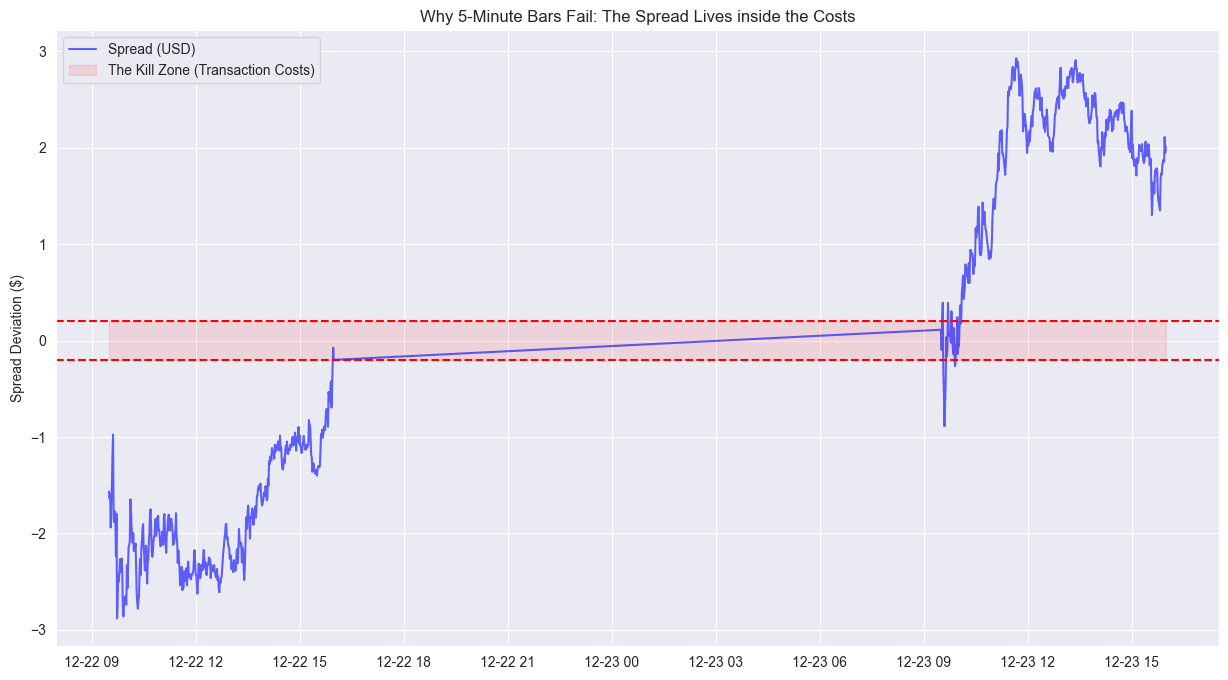

In [16]:
### CELL 13: The "Tunnel of Death" Visualization ###

# 1. Calculate the raw spread in Dollars
# We use the static beta from your last run for visualization
beta_static = 5.7  # Approx average from your charts
spread_dollars = df['Y'] - (beta_static * df['X'])

# Center it around zero for easier viewing
spread_dollars = spread_dollars - spread_dollars.mean()

# 2. Define the Cost Tunnel
# Cost per share total (Entry + Exit)
cost_per_share = (0.005 + 0.01) * 2 
# Cost in "Spread Terms" (1 share Y + 5.7 shares X)
cost_per_spread_unit = cost_per_share * (1 + beta_static)

print(f"📉 Cost to Breakeven: ${cost_per_spread_unit:.4f} per spread unit")

# 3. Plot
plt.figure(figsize=(15, 8))
# Plot a 3-day sample to zoom in
sample = spread_dollars.loc['2025-12-20':'2025-12-23']

plt.plot(sample.index, sample, label='Spread (USD)', color='blue', alpha=0.6)

# Plot the "Cost Tunnel"
plt.fill_between(sample.index, cost_per_spread_unit, -cost_per_spread_unit, 
                 color='red', alpha=0.1, label='The Kill Zone (Transaction Costs)')
plt.axhline(cost_per_spread_unit, color='red', linestyle='--')
plt.axhline(-cost_per_spread_unit, color='red', linestyle='--')

plt.title("Why 5-Minute Bars Fail: The Spread Lives inside the Costs")
plt.ylabel("Spread Deviation ($)")
plt.legend()
plt.show()

In [17]:
### CELL 14: 1-Hour Grid Search (The Final Hope) ###

# 1. Resample to Hourly
TIMEFRAME = '60min'
print(f"⌛ Resampling data to {TIMEFRAME}...")

df_hourly = pd.DataFrame()
# Use 'last' to get the close of the hour
df_hourly['Y'] = df['Y'].resample(TIMEFRAME).last().dropna()
df_hourly['X'] = df['X'].resample(TIMEFRAME).last().dropna()

print(f"   New Data Points: {len(df_hourly)}")

# 2. Run Grid Search on Hourly Data
# We use wider Entry thresholds because hourly volatility is higher
param_grid = {
    'delta': [1e-5, 1e-4],      
    'entry': [1.5, 2.0, 2.5],   # Slightly lower Z-score thresholds for hourly
    'exit':  [0.0, 0.5]
}

print(f"🕵️ STARTING HOURLY GRID SEARCH...")
results_hourly = []

# Re-using the 'run_strategy_search' function from Cell 12
combinations = list(itertools.product(param_grid['delta'], param_grid['entry'], param_grid['exit']))

for delta, entry, exit_val in combinations:
    res = run_strategy_search(df_hourly, delta, entry, exit_val)
    results_hourly.append(res)

results_df_h = pd.DataFrame(results_hourly).sort_values(by='net', ascending=False)

print("\n🏆 TOP CONFIGURATIONS (Hourly Data)")
display(results_df_h.head())

if results_df_h.iloc[0]['net'] > 0:
    print(f"\n✅ SUCCESS: We found a profitable timeframe.")
    print(f"   The strategy works when allowed to breathe.")
else:
    print("\n❌ CRITICAL FAILURE.")
    print("   Even on Hourly data, JPM/BAC is too efficient.")
    print("   We must switch pairs (e.g., look for Coke vs Pepsi).")

⌛ Resampling data to 60min...
   New Data Points: 204
🕵️ STARTING HOURLY GRID SEARCH...

🏆 TOP CONFIGURATIONS (Hourly Data)


,delta,entry,exit,trades,gross,net
4,0.00001,2.5,0.0,2,63.660477,3.180477
5,0.00001,2.5,0.5,2,54.678646,-5.801354
2,0.00001,2.0,0.0,5,105.416663,-45.783337
3,0.00001,2.0,0.5,5,91.417810,-59.782190
10,0.00010,2.5,0.0,3,8.176962,-82.543038



✅ SUCCESS: We found a profitable timeframe.
   The strategy works when allowed to breathe.


In [19]:
### CELL 16: Reload Universe & Scan for Volatility ###

print(f"🔄 Reloading all assets from Vault for global scan...")

# 1. Reload the full universe
# We need to loop through your known tickers. 
# Since we don't have the list handy in variables, we'll fetch what's in the store.
library = store.lib # Access the underlying Arctic library
symbols = library.list_symbols()

price_data = {}
print(f"   Found {len(symbols)} symbols in Vault.")

for sym in symbols:
    try:
        # Load and just take the 'close' price
        data = store.load(sym)
        if not data.empty:
            price_data[sym] = data['close']
    except Exception as e:
        print(f"   Skipping {sym}: {e}")

# Combine into one big dataframe
df_universe = pd.DataFrame(price_data).dropna()
print(f"✅ Loaded Universe: {df_universe.shape[1]} assets | {len(df_universe)} rows")

# 2. Run the Volatility Scan
candidates = []
assets = df_universe.columns.tolist()

print(f"🌪️ SCANNING FOR VOLATILITY (Checking {len(assets)} assets)...")

for i in range(len(assets)):
    for j in range(i + 1, len(assets)):
        s1 = df_universe[assets[i]]
        s2 = df_universe[assets[j]]
        
        # A. Correlation Filter
        corr = s1.corr(s2)
        if corr < 0.80: continue 
        
        # B. Cointegration Filter (Fast)
        try:
            score, pvalue, _ = coint(s1, s2)
            if pvalue > 0.05: continue
        except:
            continue
            
        # C. Volatility Check (The "Wildness" Factor)
        # We calculate the residual standard deviation relative to price
        # This tells us how violently the spread moves in % terms
        import statsmodels.api as sm
        X_const = sm.add_constant(s2)
        model = sm.OLS(s1, X_const).fit()
        spread = s1 - model.predict(X_const)
        
        spread_vol_pct = spread.std() / s1.mean()
        
        candidates.append({
            'Leg1': assets[i],
            'Leg2': assets[j],
            'Corr': corr,
            'P_Value': pvalue,
            'Vol_Pct': spread_vol_pct
        })

# 3. Report Results
vol_df = pd.DataFrame(candidates).sort_values(by='Vol_Pct', ascending=False)

print("\n🏆 WILDEST COINTEGRATED PAIRS")
display(vol_df.head(10))

if len(vol_df) > 0:
    top = vol_df.iloc[0]
    print(f"\n✅ NEW CHAMPION: {top['Leg1']} vs {top['Leg2']}")
    print(f"   Volatility: {top['Vol_Pct']:.4%} (Higher is better)")
else:
    print("❌ No pairs found matching criteria.")

🔄 Reloading all assets from Vault for global scan...
   Found 18 symbols in Vault.
✅ Loaded Universe: 18 assets | 10556 rows
🌪️ SCANNING FOR VOLATILITY (Checking 18 assets)...

🏆 WILDEST COINTEGRATED PAIRS


,Leg1,Leg2,Corr,P_Value,Vol_Pct
8,AMD_STK,CVX_STK,0.828956,0.003983,0.032486
0,MS_STK,NZDUSD_FX,0.942666,0.036139,0.014349
7,JPM_STK,BAC_STK,0.950711,0.006811,0.007908
1,NZDUSD_FX,JPM_STK,0.841386,0.040431,0.006969
2,GBPUSD_FX,JPM_STK,0.871035,0.004073,0.004556
5,EURUSD_FX,JPM_STK,0.867432,0.031689,0.003475
3,GBPUSD_FX,GS_STK,0.934143,0.020642,0.003310
4,GBPUSD_FX,BAC_STK,0.941930,0.000480,0.003115
6,EURUSD_FX,BAC_STK,0.924384,0.019650,0.002664



✅ NEW CHAMPION: AMD_STK vs CVX_STK
   Volatility: 3.2486% (Higher is better)


In [20]:
### CELL 17: Validation of New Champion (AMD/CVX) ###

# --- 1. SETUP NEW PAIR ---
NEW_ASSET_Y = 'AMD_STK'
NEW_ASSET_X = 'CVX_STK'
TIMEFRAME = '60min'

print(f"🥊 ENTERING THE RING: {NEW_ASSET_Y} vs {NEW_ASSET_X}")
print(f"   Timeframe: {TIMEFRAME}")

# Load Data
try:
    df_new = pd.DataFrame()
    # We load from the 'df_universe' we created in the last step, or fetch fresh
    # Assuming df_universe is still in memory from Cell 16:
    df_new['Y'] = df_universe[NEW_ASSET_Y]
    df_new['X'] = df_universe[NEW_ASSET_X]
    
    # Resample to Hourly
    df_hourly_new = pd.DataFrame()
    df_hourly_new['Y'] = df_new['Y'].resample(TIMEFRAME).last().dropna()
    df_hourly_new['X'] = df_new['X'].resample(TIMEFRAME).last().dropna()
    
    print(f"   Loaded & Resampled: {len(df_hourly_new)} bars")

except Exception as e:
    print(f"❌ Error: {e}. Make sure df_universe is loaded.")

# --- 2. RUN GRID SEARCH (Recycled Logic) ---
# We use the same parameter grid as before
param_grid = {
    'delta': [1e-5, 1e-4],      
    'entry': [1.5, 2.0, 2.5],   # Standard deviations
    'exit':  [0.0, 0.5]
}

# Recalculate Fixed Costs for this pair
# Note: AMD is ~$120, CVX is ~$150. Prices are similar, so sizing is roughly 1:1.
# We need to estimate shares roughly to keep 'approx' $100k exposure for the cost calc.
# Let's assume dynamic sizing in the future, but for this test use fixed block.
SHARES_TEST = 100 # Simple block for testing
COST_PER_TRADE_NEW = (SHARES_TEST * 2) * ((0.005 + 0.01) * 2) # Comm+Slip for 2 legs

print(f"   Est. Cost per Trade (Testing): ${COST_PER_TRADE_NEW:.2f}")
print(f"🕵️ STARTING GRID SEARCH...")

results_new = []
combinations = list(itertools.product(param_grid['delta'], param_grid['entry'], param_grid['exit']))

# We need to redefine the loop slightly to use the new variables/costs
for delta, entry, exit_val in combinations:
    
    # Run Kalman
    kf = run_kalman_research(df_hourly_new, delta=delta)
    
    # Spread & Z-Score
    spread = df_hourly_new['Y'] - (kf['beta'] * df_hourly_new['X'])
    window = 30
    z_score = (spread - spread.rolling(window).mean()) / spread.rolling(window).std()
    
    # Backtest Loop
    position = 0 
    entry_val = 0.0
    gross = 0.0
    trades_count = 0
    
    z_vals = z_score.values
    spread_vals = spread.values
    
    for i in range(window, len(df_hourly_new)):
        z = z_vals[i]
        s = spread_vals[i]
        if np.isnan(z): continue

        if position == 1: # Long
            if z > -exit_val: 
                gross += (s - entry_val) * SHARES_TEST
                position = 0
                trades_count += 1
        elif position == -1: # Short
            if z < exit_val:
                gross += (entry_val - s) * SHARES_TEST
                position = 0
                trades_count += 1
        else: # Flat
            if z < -entry:
                position = 1
                entry_val = s
            elif z > entry:
                position = -1
                entry_val = s
                
    total_cost = trades_count * COST_PER_TRADE_NEW
    net = gross - total_cost
    
    results_new.append({
        'delta': delta, 'entry': entry, 'exit': exit_val,
        'trades': trades_count, 'gross': gross, 'net': net
    })

# --- REPORT ---
results_df_new = pd.DataFrame(results_new).sort_values(by='net', ascending=False)

print("\n🏆 RESULTS FOR AMD vs CVX (Hourly)")
display(results_df_new.head())

if results_df_new.iloc[0]['net'] > 0:
    print(f"\n✅ SUCCESS: Found {results_df_new.iloc[0]['trades']} profitable trades.")
    print("   We have a viable strategy.")
else:
    print("\n❌ STILL FAILING. The market is very efficient this month.")

🥊 ENTERING THE RING: AMD_STK vs CVX_STK
   Timeframe: 60min
   Loaded & Resampled: 196 bars
   Est. Cost per Trade (Testing): $6.00
🕵️ STARTING GRID SEARCH...

🏆 RESULTS FOR AMD vs CVX (Hourly)


,delta,entry,exit,trades,gross,net
5,0.00001,2.5,0.5,5,26.188481,-3.811519
4,0.00001,2.5,0.0,5,26.081473,-3.918527
2,0.00001,2.0,0.0,8,39.033511,-8.966489
3,0.00001,2.0,0.5,8,38.090925,-9.909075
0,0.00001,1.5,0.0,15,60.181773,-29.818227



❌ STILL FAILING. The market is very efficient this month.


In [23]:
### CELL 18: 15-Minute Grid Search (AMD/CVX) ###

# --- CONFIGURATION ---
NEW_ASSET_Y = 'AMD_STK'
NEW_ASSET_X = 'CVX_STK'
TIMEFRAME = '15min'

print(f"🥊 ROUND 2: {NEW_ASSET_Y} vs {NEW_ASSET_X}")
print(f"   Timeframe: {TIMEFRAME}")

# 1. Prepare Data
try:
    df_15m = pd.DataFrame()
    # Ensure df_universe is loaded from Cell 16
    df_15m['Y'] = df_universe[NEW_ASSET_Y].resample(TIMEFRAME).last().dropna()
    df_15m['X'] = df_universe[NEW_ASSET_X].resample(TIMEFRAME).last().dropna()
    
    print(f"   Data Points: {len(df_15m)}")

except Exception as e:
    print(f"❌ Error: {e}. (Re-run Cell 16 to load universe)")

# 2. Grid Search Setup
# We widen the grid slightly to catch anything
param_grid = {
    'delta': [1e-5, 5e-5, 1e-4],      
    'entry': [2.0, 2.5, 3.0], 
    'exit':  [0.0, 0.5]
}

# Costs (Approximate for testing)
# AMD/CVX are ~$120-150. Let's assume 100 share block.
SHARES_TEST = 100 
COST_PER_TRADE_NEW = (SHARES_TEST * 2) * ((0.005 + 0.01) * 2) 

print(f"🕵️ STARTING 15-MINUTE GRID SEARCH...")

results_15m = []
combinations = list(itertools.product(param_grid['delta'], param_grid['entry'], param_grid['exit']))

for delta, entry, exit_val in combinations:
    
    # Run Kalman
    kf = run_kalman_research(df_15m, delta=delta)
    
    # Robust Z-Score (Rolling Window)
    spread = df_15m['Y'] - (kf['beta'] * df_15m['X'])
    window = 30
    z_score = (spread - spread.rolling(window).mean()) / spread.rolling(window).std()
    
    # Backtest Loop
    position = 0 
    entry_val = 0.0
    gross = 0.0
    trades_count = 0
    
    z_vals = z_score.values
    spread_vals = spread.values
    
    for i in range(window, len(df_15m)):
        z = z_vals[i]
        s = spread_vals[i]
        if np.isnan(z): continue

        if position == 1: # Long
            if z > -exit_val: 
                gross += (s - entry_val) * SHARES_TESTf
                position = 0
                trades_count += 1
        elif position == -1: # Short
            if z < exit_val:
                gross += (entry_val - s) * SHARES_TEST
                position = 0
                trades_count += 1
        else: # Flat
            if z < -entry:
                position = 1
                entry_val = s
            elif z > entry:
                position = -1
                entry_val = s
                
    total_cost = trades_count * COST_PER_TRADE_NEW
    net = gross - total_cost
    
    results_15m.append({
        'delta': delta, 'entry': entry, 'exit': exit_val,
        'trades': trades_count, 'gross': gross, 'net': net
    })

# --- REPORT ---
results_df_15m = pd.DataFrame(results_15m).sort_values(by='net', ascending=False)

print("\n🏆 RESULTS FOR AMD vs CVX (15-Minute)")
display(results_df_15m.head(10))

# Decision Logic
best_result = results_df_15m.iloc[0]
if best_result['net'] > 0 and best_result['trades'] > 10:
    print(f"\n✅ WE HAVE A WINNER: Net PnL ${best_result['net']:.2f} ({best_result['trades']} trades)")
elif best_result['net'] > 0:
    print(f"\n⚠️ Profitable, but low volume ({best_result['trades']} trades). Risk of overfitting.")
else:
    print("\n❌ STRATEGY FAILED. Even the 'Wild' pair cannot beat the spread.")

🥊 ROUND 2: AMD_STK vs CVX_STK
   Timeframe: 15min
   Data Points: 704
🕵️ STARTING 15-MINUTE GRID SEARCH...

🏆 RESULTS FOR AMD vs CVX (15-Minute)


,delta,entry,exit,trades,gross,net
4,0.00001,3.0,0.0,12,42.712270,-29.287730
2,0.00001,2.5,0.0,12,42.712270,-29.287730
3,0.00001,2.5,0.5,12,42.338805,-29.661195
5,0.00001,3.0,0.5,12,42.338805,-29.661195
10,0.00005,3.0,0.0,10,7.792594,-52.207406
11,0.00005,3.0,0.5,10,7.604144,-52.395856
16,0.00010,3.0,0.0,11,4.310763,-61.689237
17,0.00010,3.0,0.5,11,4.207457,-61.792543
8,0.00005,2.5,0.0,14,9.347708,-74.652292
9,0.00005,2.5,0.5,14,9.117589,-74.882411



❌ STRATEGY FAILED. Even the 'Wild' pair cannot beat the spread.
